In [1]:
import pickle

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score


# Function
def save_pkl(obj: any, name: str):
    """Saves an object to a pickle file, ensuring proper file extension and security.

    Args:
        obj: The object to serialize and save.
        name (str): The desired filename or path.
            - If it doesn't end with ".pkl", `.pkl` will be appended.
            - Supports relative and absolute paths.
        protocol (int, optional): The pickle protocol version to use. Defaults to the
            highest compatible with the current Python version.

    Raises:
        ValueError: If `name` is an empty string or if file operations fail.
        PickleError: If pickling encounters an error.
    """

    
    if len(name) == 0:
        raise ValueError("Filename cannot be empty")

    if not name.endswith(".pkl"):
        name += ".pkl"

    try:
        with open(name, 'wb') as file:
            pickle.dump(obj, file)
    except (OSError, IOError) as e:
        raise ValueError(f"Failed to save pickle file: {e}") from e
    except pickle.PickleError as e:
        raise pickle.PickleError(f"Pickling error: {e}") from e

    print(f"Saved: \"{name}\"")

def load_pkl(name: str):
    if len(name) == 0:
        raise ValueError("Filename cannot be empty")

    with open(name, 'rb') as file:
        return pickle.load(file)

def model_information(model, X_test, y_test):
    import numpy as np
    import matplotlib.pyplot as plt
    
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Overall accuracy model:")
    print(f"Accuracy  = {accuracy*100:<.2f}%")
    print(f"Precision = {precision*100:<.2f}%")
    print(f"Recall    = {recall*100:<.2f}%")
    print(f"F1-score  = {f1*100:<.2f}%\n")
    
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    heatmap = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    labels = np.unique(y_test)

    print("Accuracy model for each label:")
    for label in labels:
        idx = np.where(model.classes_ == label)[0][0]
        label_accuracy = cm[idx, idx] / np.sum(cm[idx, :])
        print(f"{label:<14s}= {label_accuracy*100:.2f}%")

    heatmap.plot()
    plt.show()


In [2]:
# Read dataset
df = pd.read_csv('../data/imo.csv')


df_notna = df[df["label"].notna()]
df_notna.reset_index(drop=True, inplace=True)

number_of_occurrences = [
    df_notna[df_notna['label'] == 'Algebra'].shape[0],
    df_notna[df_notna['label'] == 'Combinatorics'].shape[0],
    df_notna[df_notna['label'] == 'Geometry'].shape[0],
    df_notna[df_notna['label'] == 'Number Theory'].shape[0]
]
print(f"Algebra       = {number_of_occurrences[0]}")
print(f"Combinatorics = {number_of_occurrences[1]}")
print(f"Geometry      = {number_of_occurrences[2]}")
print(f"Number Theory = {number_of_occurrences[3]}")


Algebra       = 726
Combinatorics = 630
Geometry      = 1164
Number Theory = 704


In [3]:
# Kurangi soal geometry
aa = df_notna[df_notna['label'] == "Algebra"].sample(726)
cc = df_notna[df_notna['label'] == "Combinatorics"].sample(630)
gg = df_notna[df_notna['label'] == "Geometry"].sample(790)
nt = df_notna[df_notna['label'] == "Number Theory"].sample(704)
df_notna = pd.concat([aa, cc, gg, nt], axis=0)

# Shuffle 
df_notna = df_notna.sample(frac=1, random_state=42)
df_notna.reset_index(drop=True, inplace=True)

# Split
X, y = df_notna["post_canonical"], df_notna["label"]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline with TF-IDF vectorizer and MLP classifier
clf = make_pipeline(
    TfidfVectorizer(),
    MLPClassifier(
        hidden_layer_sizes=(900, 600, 300,), 
        activation="logistic",
        solver="adam",
        alpha=0.00012,
        batch_size="auto",
        learning_rate='constant',
        learning_rate_init=0.00012,
        power_t=0.5,
        max_iter=1050,
        shuffle=True, 
        random_state=42
        )
)

# Training the classifier
clf.fit(X_train, y_train)

# Predicting labels for the test set
y_pred = clf.predict(X_test)


Overall accuracy model:
Accuracy  = 85.61%
Precision = 86.23%
Recall    = 85.61%
F1-score  = 85.76%

Accuracy model for each label:
Algebra       = 80.00%
Combinatorics = 89.19%
Geometry      = 91.25%
Number Theory = 82.73%


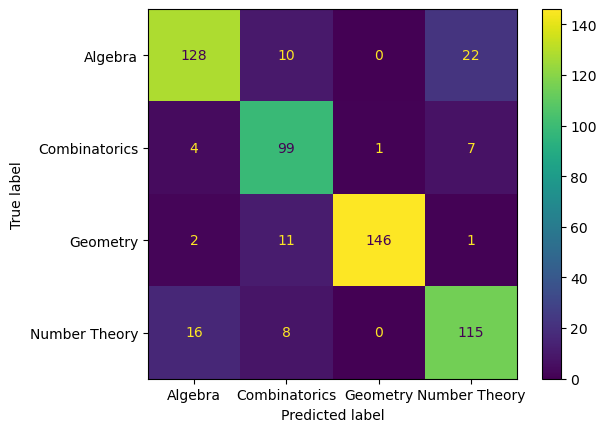

In [5]:
model_information(clf, X_test, y_test)

In [6]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

      Algebra       0.85      0.80      0.83       160
Combinatorics       0.77      0.89      0.83       111
     Geometry       0.99      0.91      0.95       160
Number Theory       0.79      0.83      0.81       139

     accuracy                           0.86       570
    macro avg       0.85      0.86      0.85       570
 weighted avg       0.86      0.86      0.86       570



In [7]:
print(confusion_matrix(y_test, y_pred))

[[128  10   0  22]
 [  4  99   1   7]
 [  2  11 146   1]
 [ 16   8   0 115]]
